
## Task 1. Loading and Preprocessing the Dataset for the Classification Problem

**1.1 Loading the dataset**

In [2]:
# importing libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
import numpy as np
from matplotlib import pyplot
from numpy import argmax
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [156]:
# loading the dataset and displaying the first rows
df1 = pd.read_excel("/kaggle/input/dataset1/dataset1.xlsx")
df1.head()

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,Micronesia,138.0,393.00,no,2019-07-20 13:21:37
1,0,446.06,666.182,Dominica,81.0,352.05,yes,2019-04-04 21:30:46
2,1,235.50,398.097,Isle of Man,90.0,339.00,no,2019-03-03 02:59:37
3,0,306.02,518.163,Turkmenistan,102.0,439.25,yes,2019-03-19 08:00:58
4,0,453.08,600.156,Cameroon,105.0,422.95,no,2019-03-18 13:22:35


**1.2 Exploring the dataset**

In [157]:
# the dimensions of the dataset
print("Dataset shape:", df1.shape)

# checking the column names and data types
print("Column names and data types:")
print(df1.dtypes)

# statistics for numerical columns
print("Statistics for numerical columns:")
print(df1.describe())

# checking for missing values
print("Missing values per column:")
print(df1.isnull().sum())

Dataset shape: (925, 8)
Column names and data types:
target      int64
var1      float64
var2      float64
var3       object
var4      float64
var5      float64
var6       object
var7       object
dtype: object
Statistics for numerical columns:
           target        var1        var2        var4        var5
count  925.000000  925.000000  925.000000  325.000000  925.000000
mean     0.496216  360.116562  548.390134  108.452308  325.393946
std      0.500256   87.866662  135.221460   26.325744   78.862779
min      0.000000  209.560000  139.965000   57.000000  163.000000
25%      0.000000  278.640000  467.373000   87.000000  257.900000
50%      0.000000  367.640000  569.841000  105.000000  342.350000
75%      1.000000  437.600000  652.278000  126.000000  393.000000
max      1.000000  539.920000  794.848000  180.000000  457.150000
Missing values per column:
target      0
var1        0
var2        0
var3        0
var4      600
var5        0
var6        0
var7        0
dtype: int64


Based on the exploratory data analysis results, the dataset contains 925 rows and 8 columns. The target variable is an integer with values 0 and 1. It's a binary classification problem, and our goal is to predict whether a unit belongs to class 0 or class 1. 

var1, var2, var4 and var5 are numerical features. var3 and var6 are categorical features. var7 is a date-time feature. var4 has only 325 counts that means that there are 600 missing values, which is significant. 

The mean value of the target variable is close to 0.5, which indicated that roughly half the instances belong to class 0, and the other half to class 1. I also visualized the distribution of the target variable, which confirms this observation.

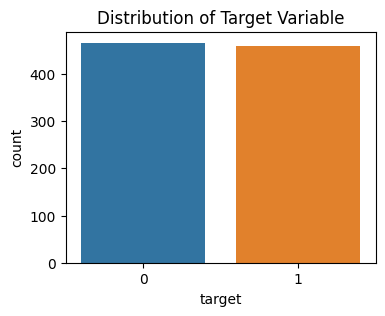

In [158]:
# visualizing the distribution of the target variable
plt.figure(figsize=(4, 3))
sns.countplot(x='target', data=df1)
plt.title('Distribution of Target Variable')
plt.show()

Let's also visualise the numerical features to understand their spread and central tendencies:

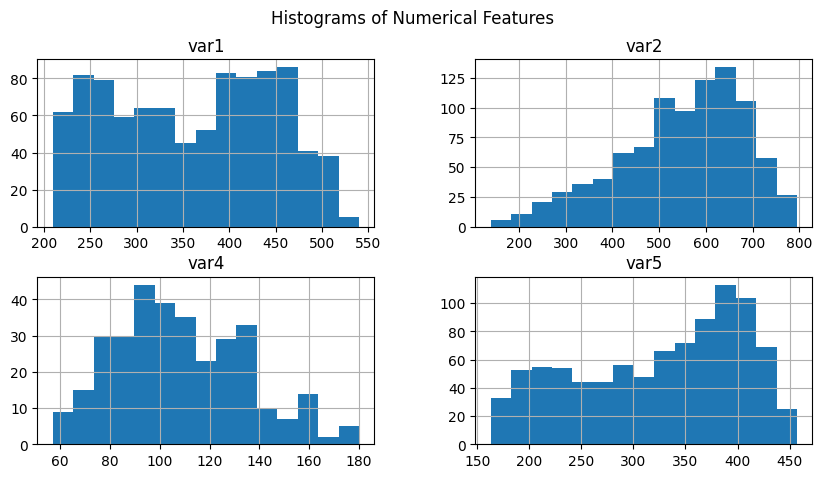

In [159]:
# the distribution of numerical features
numerical_features = ['var1', 'var2', 'var4', 'var5']
df1[numerical_features].hist(bins=15, figsize=(10, 5))
plt.suptitle('Histograms of Numerical Features')
plt.show()

We see that the distributions of var2 and var5 are right-skewed, with a higher concentration of values towards the higher end. var1 appears to be bimodal, showing multiple peaks. var4 has a higher concentration of values in the central part of its range, indicating a somewhat bimodal pattern.


**1.3. Preprocessing the dataset**

Based on the statistical analysis observed in the previous sub-section, we will handle the data in the following way: We will convert var3 and var6 values into numerical features. We will convert var7 into a float. Given the high proportion of missing values for var4, one of the options is not to include it in the features to consider for training and testing.

**1.3.1. Replacing var3 with WOE**

In [160]:
# counting the number of unique values for var3
unique_var3 = df1['var3'].nunique()
print(f"Number of unique values in var3 column: {unique_var3}")

Number of unique values in var3 column: 236


Since we have a big number of values for this categorical feature, I have opted for using Weight of Evidence, which not only converts categorical values into numerical but also captures how each category influences the target variable. It is calculated based on the proportion of positive and negative outcomes for each category. Following that, the WOE values were converted into a dictionary, and the original values in var3 wre replaced by their correcsponding WOE value. 

In [132]:

# calculating the proportion of target = 1 for each category in 'var3'
prob_df = df1.groupby('var3')['target'].mean()

# the proportion of target = 0 for each category in 'var3'
prob_df = pd.DataFrame(prob_df).assign(Distr_0 = 1 - prob_df)

# adding a small number to avoid division by zero and taking log of zero
small_const = 0.00001
prob_df = prob_df.assign(target = lambda df: df['target'] + small_const,
                         Distr_0 = lambda df: df['Distr_0'] + small_const)

# calculating WOE for each category in 'var3'
woe_df = prob_df.assign(WOE = np.log(prob_df['target'] / prob_df['Distr_0']))

print(woe_df['WOE'].head())

var3
Afghanistan        0.693132
Albania            0.287676
Algeria            0.000000
American Samoa     0.405457
Andorra           11.512935
Name: WOE, dtype: float64


In [161]:
# converting WOE values into a dictionary
woe_dict = woe_df['WOE'].to_dict()

# replacing the original values in var3 with their correcsponding WOE values
df1['var3'] = df1['var3'].map(woe_dict)

print(df1['var3'].head())

0    -0.287676
1    -1.098586
2    -0.693132
3     0.000000
4   -11.512935
Name: var3, dtype: float64


**1.3.2. Handling date-time feature 'var7'**

To handle date-time features, I initially converted them from object to datetime format, with errors='coerce' to hanle invalid values as well. I identified then invalid dates and manually corrected them (specifically, changed Ferbuary 29 2019 to February 28 2019). Finally, all the datetime values were converted to Unix timestamps to facilitate the subsequent model exploration and training.

In [162]:
# converting `var7` to datetime with error handling
df1['var7_converted'] = pd.to_datetime(df1['var7'], errors='coerce')

In [163]:
# identifying invalid dates
invalid_dates = df1[df1['var7_converted'].isna()]
print("Invalid dates found in var7 column:")
print(invalid_dates[['var7']])

Invalid dates found in var7 column:
                    var7
345  2019-02-29 12:31:57
526  2019-02-29 18:06:21
632  2019-02-29 11:00:06
779  2019-02-29 23:56:06
813  2019-02-29 19:26:35


In [164]:
# manually correcting the invalid dates
df1.loc[df1.index == 345, 'var7'] = '2019-02-28 12:31:57'
df1.loc[df1.index == 526, 'var7'] = '2019-02-28 18:06:21'
df1.loc[df1.index == 632, 'var7'] = '2019-02-28 11:00:06'
df1.loc[df1.index == 779, 'var7'] = '2019-02-28 23:56:06'
df1.loc[df1.index == 813, 'var7'] = '2019-02-28 19:26:35'

df1['var7_converted'] = pd.to_datetime(df1['var7'])

In [165]:
# converting datetime to Unix timestamp
df1['var7_float'] = df1['var7_converted'].apply(lambda x: x.timestamp()).astype(float)

print(df1[['var7_converted', 'var7_float']].head())

       var7_converted    var7_float
0 2019-07-20 13:21:37  1.563629e+09
1 2019-04-04 21:30:46  1.554413e+09
2 2019-03-03 02:59:37  1.551582e+09
3 2019-03-19 08:00:58  1.552982e+09
4 2019-03-18 13:22:35  1.552915e+09


**1.3.3. Encoding var6**

For coverting the vategorical variable var6 I used LabelEncoder for simplicity and because it is well suited for binary values like yes and no. 

In [166]:
# encoding the categorical variable with LabelEncoder
encoder_var6 = LabelEncoder()
df1['var6'] = encoder_var6.fit_transform(df1['var6'])

print(df1['var6'].head())

0    0
1    1
2    0
3    1
4    0
Name: var6, dtype: int64


**1.3.4. Handling missing values for var4**

For var4 we have a significant portion of missing data (600 out of 925 values). For imputing the missing values I applied a commonly recommended technique of using linear regression to predict and fill in the missing data, as discussed in the review by Lin and Tsai (2019). Other alternative solutions attempted included mean/median imputation, KNN imputation, drop of the entire column, but they lead to lower overall performance. 

In [167]:
# defining features and target variable for predicting var4 missing values
features_var4 = ['var1', 'var2', 'var3', 'var5', 'var6', 'var7_float', 'target']
target_var4 = 'var4'

# splitting the data into rows where var4 is missing and not missing
df_missing_var4 = df1[df1[target_var4].isnull()]
df_not_missing_var4 = df1.dropna(subset=[target_var4])

# defining features and target variable for training
x_train_var4 = df_not_missing_var4[features_var4]
y_train_var4 = df_not_missing_var4[target_var4]

# Define features for missing values prediction
x_missing_var4 = df_missing_var4[features_var4]

In [168]:
model_var4 = LinearRegression()
model_var4.fit(x_train_var4, y_train_var4)

LinearRegression()

In [169]:
# predicting missing values
predicted_values = model_var4.predict(x_missing_var4)

# filling in missing values in the original dataframe
df1.loc[df1['var4'].isnull(), target_var4] = predicted_values

In [170]:
# Check if there are any missing values left
print("Missing values for var4 after imputation:")
print(df1['var4'].isnull().sum())

Missing values for var4 after imputation:
0


**1.3.4. Dataset after cleaning and preprocessing**

In [171]:
print(df1.head())

   target    var1     var2       var3   var4    var5  var6  \
0       0  509.18  417.681  -0.287676  138.0  393.00     0   
1       0  446.06  666.182  -1.098586   81.0  352.05     1   
2       1  235.50  398.097  -0.693132   90.0  339.00     0   
3       0  306.02  518.163   0.000000  102.0  439.25     1   
4       0  453.08  600.156 -11.512935  105.0  422.95     0   

                  var7      var7_converted    var7_float  
0  2019-07-20 13:21:37 2019-07-20 13:21:37  1.563629e+09  
1  2019-04-04 21:30:46 2019-04-04 21:30:46  1.554413e+09  
2  2019-03-03 02:59:37 2019-03-03 02:59:37  1.551582e+09  
3  2019-03-19 08:00:58 2019-03-19 08:00:58  1.552982e+09  
4  2019-03-18 13:22:35 2019-03-18 13:22:35  1.552915e+09  


**1.3.5. Splitting the data**

When splitting the data into train and test sets, I will keep the equal proportions of both classes in both sets to avoid bias and for better results.

In [172]:
print(df1.columns)

Index(['target', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7',
       'var7_converted', 'var7_float'],
      dtype='object')


In [173]:
# defining the features and target variable. As explained earlier, we preferred not to include var4 due to the high number of missing values. 
features = ['var1', 'var2', 'var3', 'var5', 'var4', 'var6', 'var7_float']
target = 'target'

# splitting the data, using stratify option to create splits with the same proportion of classes 0 and 1 in both sets
x1_train, x1_test, y1_train, y1_test = train_test_split(df1[features], df1[target], test_size=0.2, stratify=df1[target], random_state=42)

# Comparing the proportion of samples with value '1' in train and test sets, making sure they are approximately the same
print('% of positive samples in train set:', sum(y1_train == 1) / len(y1_train))
print('% of positive samples in test set:', sum(y1_test == 1) / len(y1_test))

% of positive samples in train set: 0.49594594594594593
% of positive samples in test set: 0.4972972972972973


While feature scaling is not necessary for tree-based models, it is important for Logistic Regression. Since I will be comparing the performance of different models in the following section, I will use Min-Max scaling as a normalisation technique. 

In [174]:
# adding Min-Max scaling
scaler = MinMaxScaler()
scaler.fit(x1_train)
x1_train = pd.DataFrame(scaler.transform(x1_train), columns=x1_train.columns)
x1_test = pd.DataFrame(scaler.transform(x1_test), columns=x1_test.columns)

print(x1_train.head())

       var1      var2      var3      var5      var4  var6  var7_float
0  0.282675  0.798813  0.512494  0.405575  0.541285   1.0    0.474746
1  0.879001  0.628218  0.469898  0.635220  0.300652   1.0    0.692138
2  0.274551  0.731204  0.547711  0.612103  0.565518   1.0    0.489684
3  0.663312  0.972995  0.560204  0.574537  0.274199   1.0    0.761066
4  0.093174  0.434971  0.530102  0.323474  0.780488   0.0    0.154856


## Task 2. Building a classifier for the classification problem

For this task, I decided to quick scan for three algorithms: Logistic Regression, Decision Tree and Random Forest to later choose the one that provided the best output and fine-tune it. I chose them because they are interpretable. Logistic Regression is good when the relationship between the target and features is linear, while Decision Tree and Random Forest can also capture complex relationship. I excluded ANN because it often requires  a larger dataset to achieve optimal performance, which might not be ideal given the current dataset size and scope of the analysis.

**Decision Tree**

In [175]:
# initialising and fitting the Decision Tree with default parameters
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x1_train, y1_train)
tree_pred = tree.predict(x1_test)

# calculating metrics
tree_accuracy = accuracy_score(y1_test, tree_pred)
tree_f1 = f1_score(y1_test, tree_pred)
tree_precision = precision_score(y1_test, tree_pred)
tree_recall = recall_score(y1_test, tree_pred)

print("Decision Tree Metrics:")
print(f"Accuracy: {tree_accuracy}")
print(f"F1 Score: {tree_f1}")
print(f"Precision: {tree_precision}")
print(f"Recall: {tree_recall}")

Decision Tree Metrics:
Accuracy: 0.9459459459459459
F1 Score: 0.9456521739130435
Precision: 0.9456521739130435
Recall: 0.9456521739130435


**Random Forest**

In [176]:
# initializing and fitting the Random Forest 
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(x1_train, y1_train)
rnd_pred = rnd_clf.predict(x1_test)

# calculating metrics
rnd_accuracy = accuracy_score(y1_test, rnd_pred)
rnd_f1 = f1_score(y1_test, rnd_pred)
rnd_precision = precision_score(y1_test, rnd_pred)
rnd_recall = recall_score(y1_test, rnd_pred)

print("Random Forest Metrics:")
print(f"Accuracy: {rnd_accuracy}")
print(f"F1 Score: {rnd_f1}")
print(f"Precision: {rnd_precision}")
print(f"Recall: {rnd_recall}")

Random Forest Metrics:
Accuracy: 0.9783783783783784
F1 Score: 0.9777777777777777
Precision: 1.0
Recall: 0.9565217391304348


**Logistic Regression**

In [177]:
# logistic regression 
lr = LogisticRegression()
lr.fit(x1_train, y1_train)

# logistic regression metrics
lr_pred = lr.predict(x1_test)
lr_accuracy = accuracy_score(y1_test, lr_pred)
lr_f1 = f1_score(y1_test, lr_pred)
lr_precision = precision_score(y1_test, lr_pred)
lr_recall = recall_score(y1_test, lr_pred)

print("\nLogistic Regression:")
print(f"Accuracy: {lr_accuracy}")
print(f"F1 Score: {lr_f1}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")


Logistic Regression:
Accuracy: 0.9621621621621622
F1 Score: 0.9608938547486033
Precision: 0.9885057471264368
Recall: 0.9347826086956522


All the models perform well. The Random Forest has the highest accuracy, the absolute precision and shows strong overall performance. Given that Random Forest is an ensemble of Decision Trees, it would sense to explore both models further. By fine-tuning, we can not only improve the performance of Random Forest but also understand how much a single Decision Tree can improve as well

## Task 3. Model fine-tuning

**3.1. Model fine-tuning: Decision Trees**


To find the optimal parameters for the Decision Tree, I used **Grid Search** to explore various configurations. The best parameters identified through Grid Search were then applied to the Decision Tree to improve its performance.

In [179]:
# defining parameter grid
params_tree = {
    'max_depth': [None, 10, 20, 30, 40, 50],  # depth
    'max_leaf_nodes': list(range(5, 30)),  # range of leaf nodes
    'min_samples_split': [2, 5, 10, 20],  # minimum samples to split
    'min_samples_leaf': [1, 2, 5, 10],  # minimum samples per leaf
}

# initializing Grid Search with the parameters defined
grid_search_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    params_tree,
    verbose=1,
    cv=5  # 5 folds
)

# fitting Grid Seacrh
grid_search_tree.fit(x1_train, y1_train)

# getting the best parameters
best_params_tree = grid_search_tree.best_params_

print("Best parameters found by extended GridSearchCV for Decision Tree:")
print(best_params_tree)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits
Best parameters found by extended GridSearchCV for Decision Tree:
{'max_depth': None, 'max_leaf_nodes': 22, 'min_samples_leaf': 1, 'min_samples_split': 2}


Let's now train the model with the Decision Tree with the best parameters we found using the Grid Search

In [180]:
# initialising the Decision Tree with the best parameters
best_tree = DecisionTreeClassifier(**best_params_tree, random_state=42)

# fitting the model on the training set
best_tree.fit(x1_train, y1_train)

DecisionTreeClassifier(max_leaf_nodes=22, random_state=42)

We can visualize the fine-tuned decision tree to have a clear understanding of how the model makes decisions. This visualization can help identify which features are most influential in the model's predictions and reveal any patterns or relationships in the data. 

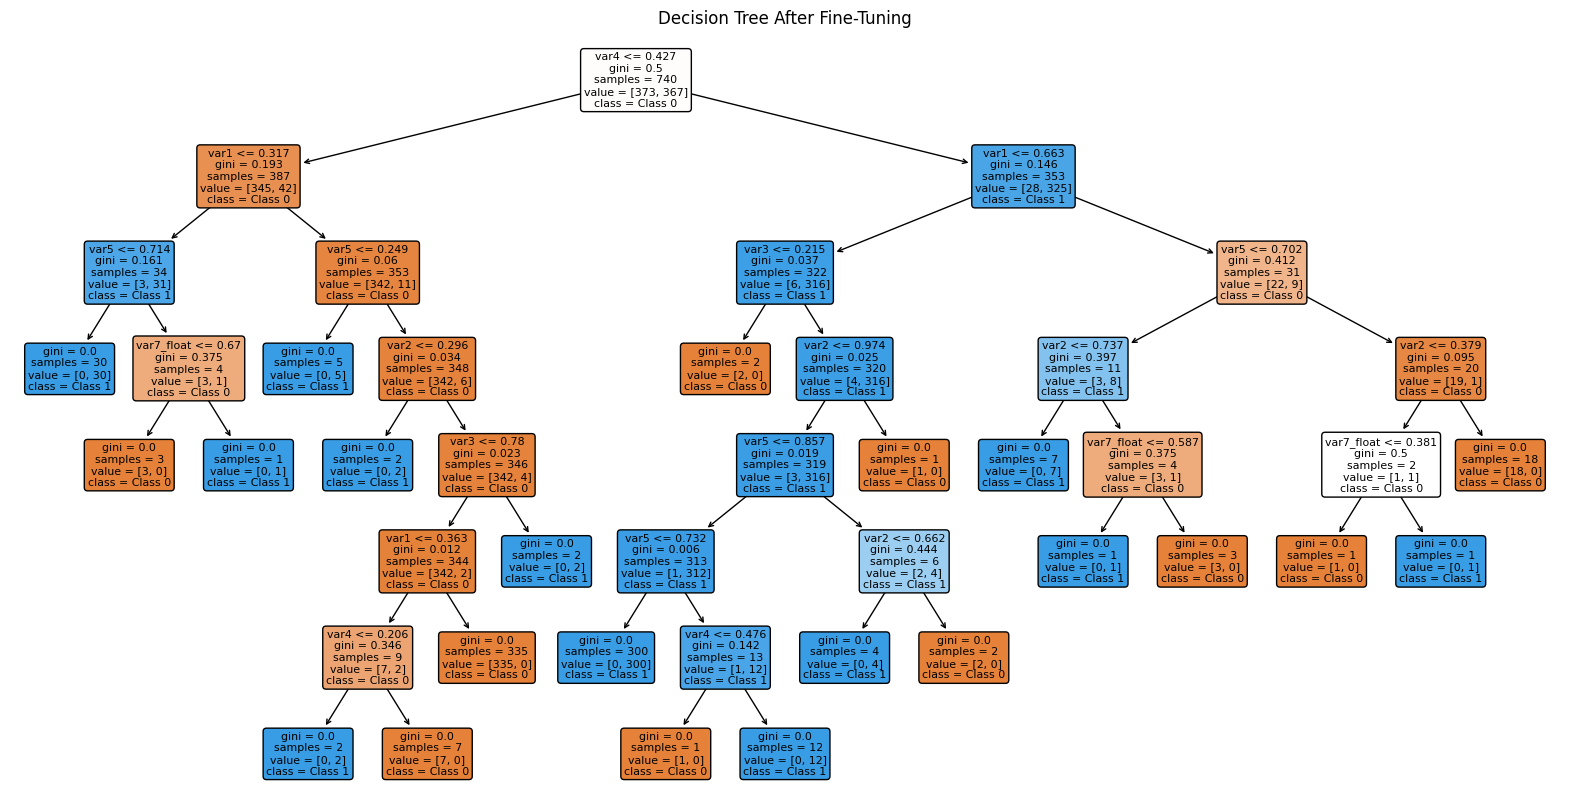

In [181]:
# plotting the fine-tuned Decision Tree
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=features, class_names=['Class 0', 'Class 1'], filled=True, rounded=True)
plt.title("Decision Tree After Fine-Tuning")
plt.show()

We can observe that var1, var2, and var5 appear frequently at higher levels of the tree, which suggests they are among the most influential features in the model’s decision-making process.

Let's now apply the improved tree to the test data:

In [182]:
# predicting on the test data
y1_pred_best_tree = best_tree.predict(x1_test)

# computing metrics
accuracy_best_tree = accuracy_score(y1_test, y1_pred_best_tree)
f1_best_tree = f1_score(y1_test, y1_pred_best_tree)
precision_best_tree = precision_score(y1_test, y1_pred_best_tree)
recall_best_tree = recall_score(y1_test, y1_pred_best_tree)

# printing metrics
print("Best Decision Tree Metrics after Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_best_tree}")
print(f"F1 Score: {f1_best_tree}")
print(f"Precision: {precision_best_tree}")
print(f"Recall: {recall_best_tree}")

Best Decision Tree Metrics after Hyperparameter Tuning:
Accuracy: 0.9675675675675676
F1 Score: 0.967391304347826
Precision: 0.967391304347826
Recall: 0.967391304347826


As we can see, the model is performing much better with the parameters set based on the Grid Search. 

**3.2. Model fine-tuning: Random Forest**

I initially attempted to use Grid Search for the Random Forest model as well but I could not improve the model's performance with the chosen parameters. As an alternative approach, I implemented the thresholding procedure to select the best threshold using the **ROC curve** and **Youden's statistics** and subsequently to apply the best threshold to apply it to our predictions.

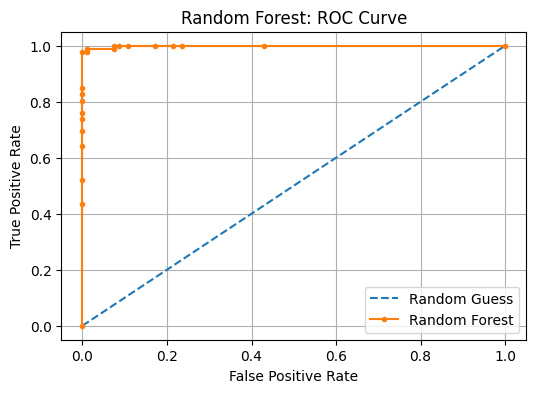

In [183]:
# predicting probabilities on the test set
y_probs_best = rnd_clf.predict_proba(x1_test)[:, 1]

# calculating ROC curves
fpr, tpr, thresholds = roc_curve(y1_test, y_probs_best)
roc_auc = auc(fpr, tpr)  # compute AUC

# plotting the ROC curve
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

The Roc curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The trade off here is between TPR against FPR. We observe that the model's performance is almost perfect, as the curve is very close to the top left corner. 

Now let's apply Youden's statistics to find the optimal threshold for our classifier. Youden's statistics is the difference between TPR and FPR . By calculating this statistics at different values, we identify the threshold that maximizes the difference

In [184]:
# Youden's J statistic to find the optimal threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold={best_thresh:.4f}')

Best Threshold=0.3800


Let's use the best threshold to refine the model's performance

In [185]:
# making predictions using the optimal threshold
rnd_optimal = (y_probs_best >= best_thresh).astype(int)

# calculating metrics
rnd_accuracy_best = accuracy_score(y1_test, rnd_optimal)
rnd_f1_best = f1_score(y1_test, rnd_optimal)
rnd_precision_best = precision_score(y1_test, rnd_optimal)
rnd_recall_best = recall_score(y1_test, rnd_optimal)

print("Fine-tuned Random Forest metrics:")
print(f"Accuracy: {rnd_accuracy_best}")
print(f"F1 Score: {rnd_f1_best}")
print(f"Precision: {rnd_precision_best}")
print(f"Recall: {rnd_recall_best}")

Fine-tuned Random Forest metrics:
Accuracy: 0.9891891891891892
F1 Score: 0.9891304347826086
Precision: 0.9891304347826086
Recall: 0.9891304347826086


As we can see, fine-tuning improved significantly the performance of the Random Forest as well, by bringing the accuracy to almost 99%.  

Thus, we can say that Decision Tree benefited from parameter optimization and the Random Forest from threshold adjustment. However,the Random Forest still demonstrated better overall metrics compared to Random Forest.

## Task 4. Visualization

The respective visualizations are provided in the following sections:

1.2 Exploring the Dataset Statistics:
- "Distribution of the Target Variable"
- "Histogram of Numerical Features"

3.1 Model Fine-Tuning: Decision Trees:
- "Decision Tree Before Fine-Tuning"
- "Decision Tree After Fine-Tuning"

3.2 Additional Model Exploration: Random Forest:
- "Random Forest: ROC Curve"

4.2. Confusion Matrix
- "Confusion Matrix for Best Decision Tree"
- "Confusion Matrix for Best Random Forest"

In this section we will plot the **feature importance** to get insights on the most influential features 

**4.1. Feature Importance visualization: Decision Tree**

The feature importance for the decision tree was calculated based on the fine-tuned model

In [186]:
# computing feature importances
importances = best_tree.feature_importances_

In [187]:
# getting feature names
feature_names = ['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7']

# creating a dataframe for visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# sorting features by importance
importances_best_tree = importances_df.sort_values(by='Importance', ascending=False)

print(importances_best_tree)

  Feature  Importance
4    var5    0.671642
0    var1    0.205343
3    var4    0.057931
1    var2    0.033171
2    var3    0.021102
6    var7    0.010812
5    var6    0.000000


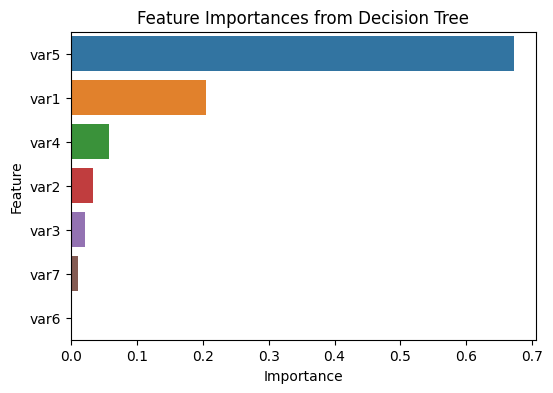

In [188]:
# plotting feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importances_best_tree)
plt.title('Feature Importances from Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**4.2 Feature importance: Random Forest**

These are calculated from the trained Random Forest model itself, irrespective of threshold adjustments. The threshold adjustment only affects classification outcomes, not feature importances.

In [71]:
# feature importances
importances = rnd_clf.feature_importances_

In [67]:
feature_names = ['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7']

# creating dataframes
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# sorting the features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

print(importances_df)

  Feature  Importance
4    var5    0.310599
0    var1    0.301543
3    var4    0.230613
1    var2    0.095231
2    var3    0.045854
6    var7    0.013012
5    var6    0.003148


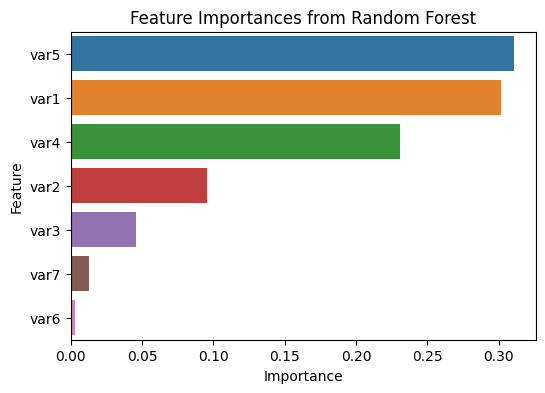

In [69]:
# plotting the feature importances for Random Forest
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Based on the plots we can observe that the Decision Tree relies heavily on var5, which is the most important feature. Other features contribute less, with var6 showing no impact.

On the other hand, the Random Forest model uses multiple important features, with var5 and var1 being the most influential. In this way, it aggregates the importance of several features rather than focusing on just one.

## Task 5. Reporting the final performance of the selected model(s)

The performance metrics for the fine-tuned Decision Tree and Random Forest models are summarized below:

In [73]:
# comparing the metrics
models_comparison = pd.DataFrame({
    'Model': ['Fine-Tuned Decision Tree', 'Fine-Tuned Random Forest'],
    'Accuracy': [accuracy_best_tree, rnd_accuracy_best],
    'F1 Score': [f1_best_tree, rnd_f1_best],
    'Precision': [precision_best_tree, rnd_precision_best],
    'Recall': [recall_best_tree, rnd_recall_best]
})

print(models_comparison)



                      Model  Accuracy  F1 Score  Precision    Recall
0  Fine-Tuned Decision Tree  0.967568  0.967391   0.967391  0.967391
1  Fine-Tuned Random Forest  0.989189  0.989130   0.989130  0.989130


The metrics reveal that the fine-tuned Random Forest outperforms the fine-tuned Decision Tree across all the metrics

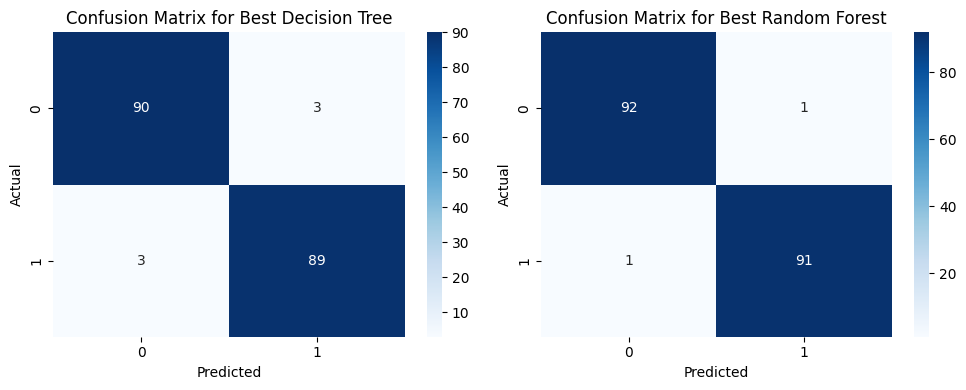

In [74]:
# confusion matrices
confusion_matrix_best_tree = confusion_matrix(y1_test, y1_pred_best_tree)
confusion_matrix_best_rnd = confusion_matrix(y1_test, rnd_optimal)

# plotting the confusion matrices 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# confusion matrix for the fine-tuned Decision Tree
sns.heatmap(confusion_matrix_best_tree, annot=True, fmt='g', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Best Decision Tree')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# confusion matrix for the fine-tuned Random Forest
sns.heatmap(confusion_matrix_best_rnd, annot=True, fmt='g', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Best Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Based on the performance metrics and confusion matrix, the fine-tuned Random Forest model demonstrates superior performance with higher accuracy (ammost 99%), precision, and recall and F1 compared to the Decision Tree. The Random Forest model has fewer false positives (1) and false negatives (1) compared to the Decision Tree (3 false positives and 3 false negatives) making it a reliable model in this classification task. 